In [1]:
import collections
import csv
import itertools
import json
import datetime
import time

#import ijson
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

In [2]:
LANGUAGES = {
    "python": "Python",
    "r": "R",
    "javascript": "Javascript",
    "java": "Java",
    "cpp": "C++",
    "php": "PHP",
    "ruby": "Ruby",
    "perl": "Perl",
    "rust": "Rust",
    "swift": "Swift",
    "objectivec": "Objective C",
    "c#": "C#",
}

In [3]:
with open("2023_data_geolocated_only.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    geo_data = {item.get("user_id"): item for item in tqdm.tqdm(reader) if item.get("user_id")}

4086252it [00:15, 270577.32it/s]


In [4]:
geo_data['1']

{'': '1523156',
 'user_id': '1',
 'date_observed': '2023-03-05T05:46:06.063',
 'location': 'El Cerrito, CA',
 'country': 'United States',
 'eFUA_name': 'San Jose'}

Processing python
	 Processing resource...
Processing r
	 Processing resource...
Processing javascript
	 Processing resource...
Processing java
	 Processing resource...
Processing cpp
	 Processing resource...
Processing php
	 Processing resource...
Processing ruby
	 Processing resource...
Processing perl
	 Processing resource...
Processing rust
	 Processing resource...
Processing swift
	 Processing resource...
Processing objectivec
	 Processing resource...
Processing c#
	 Processing resource...


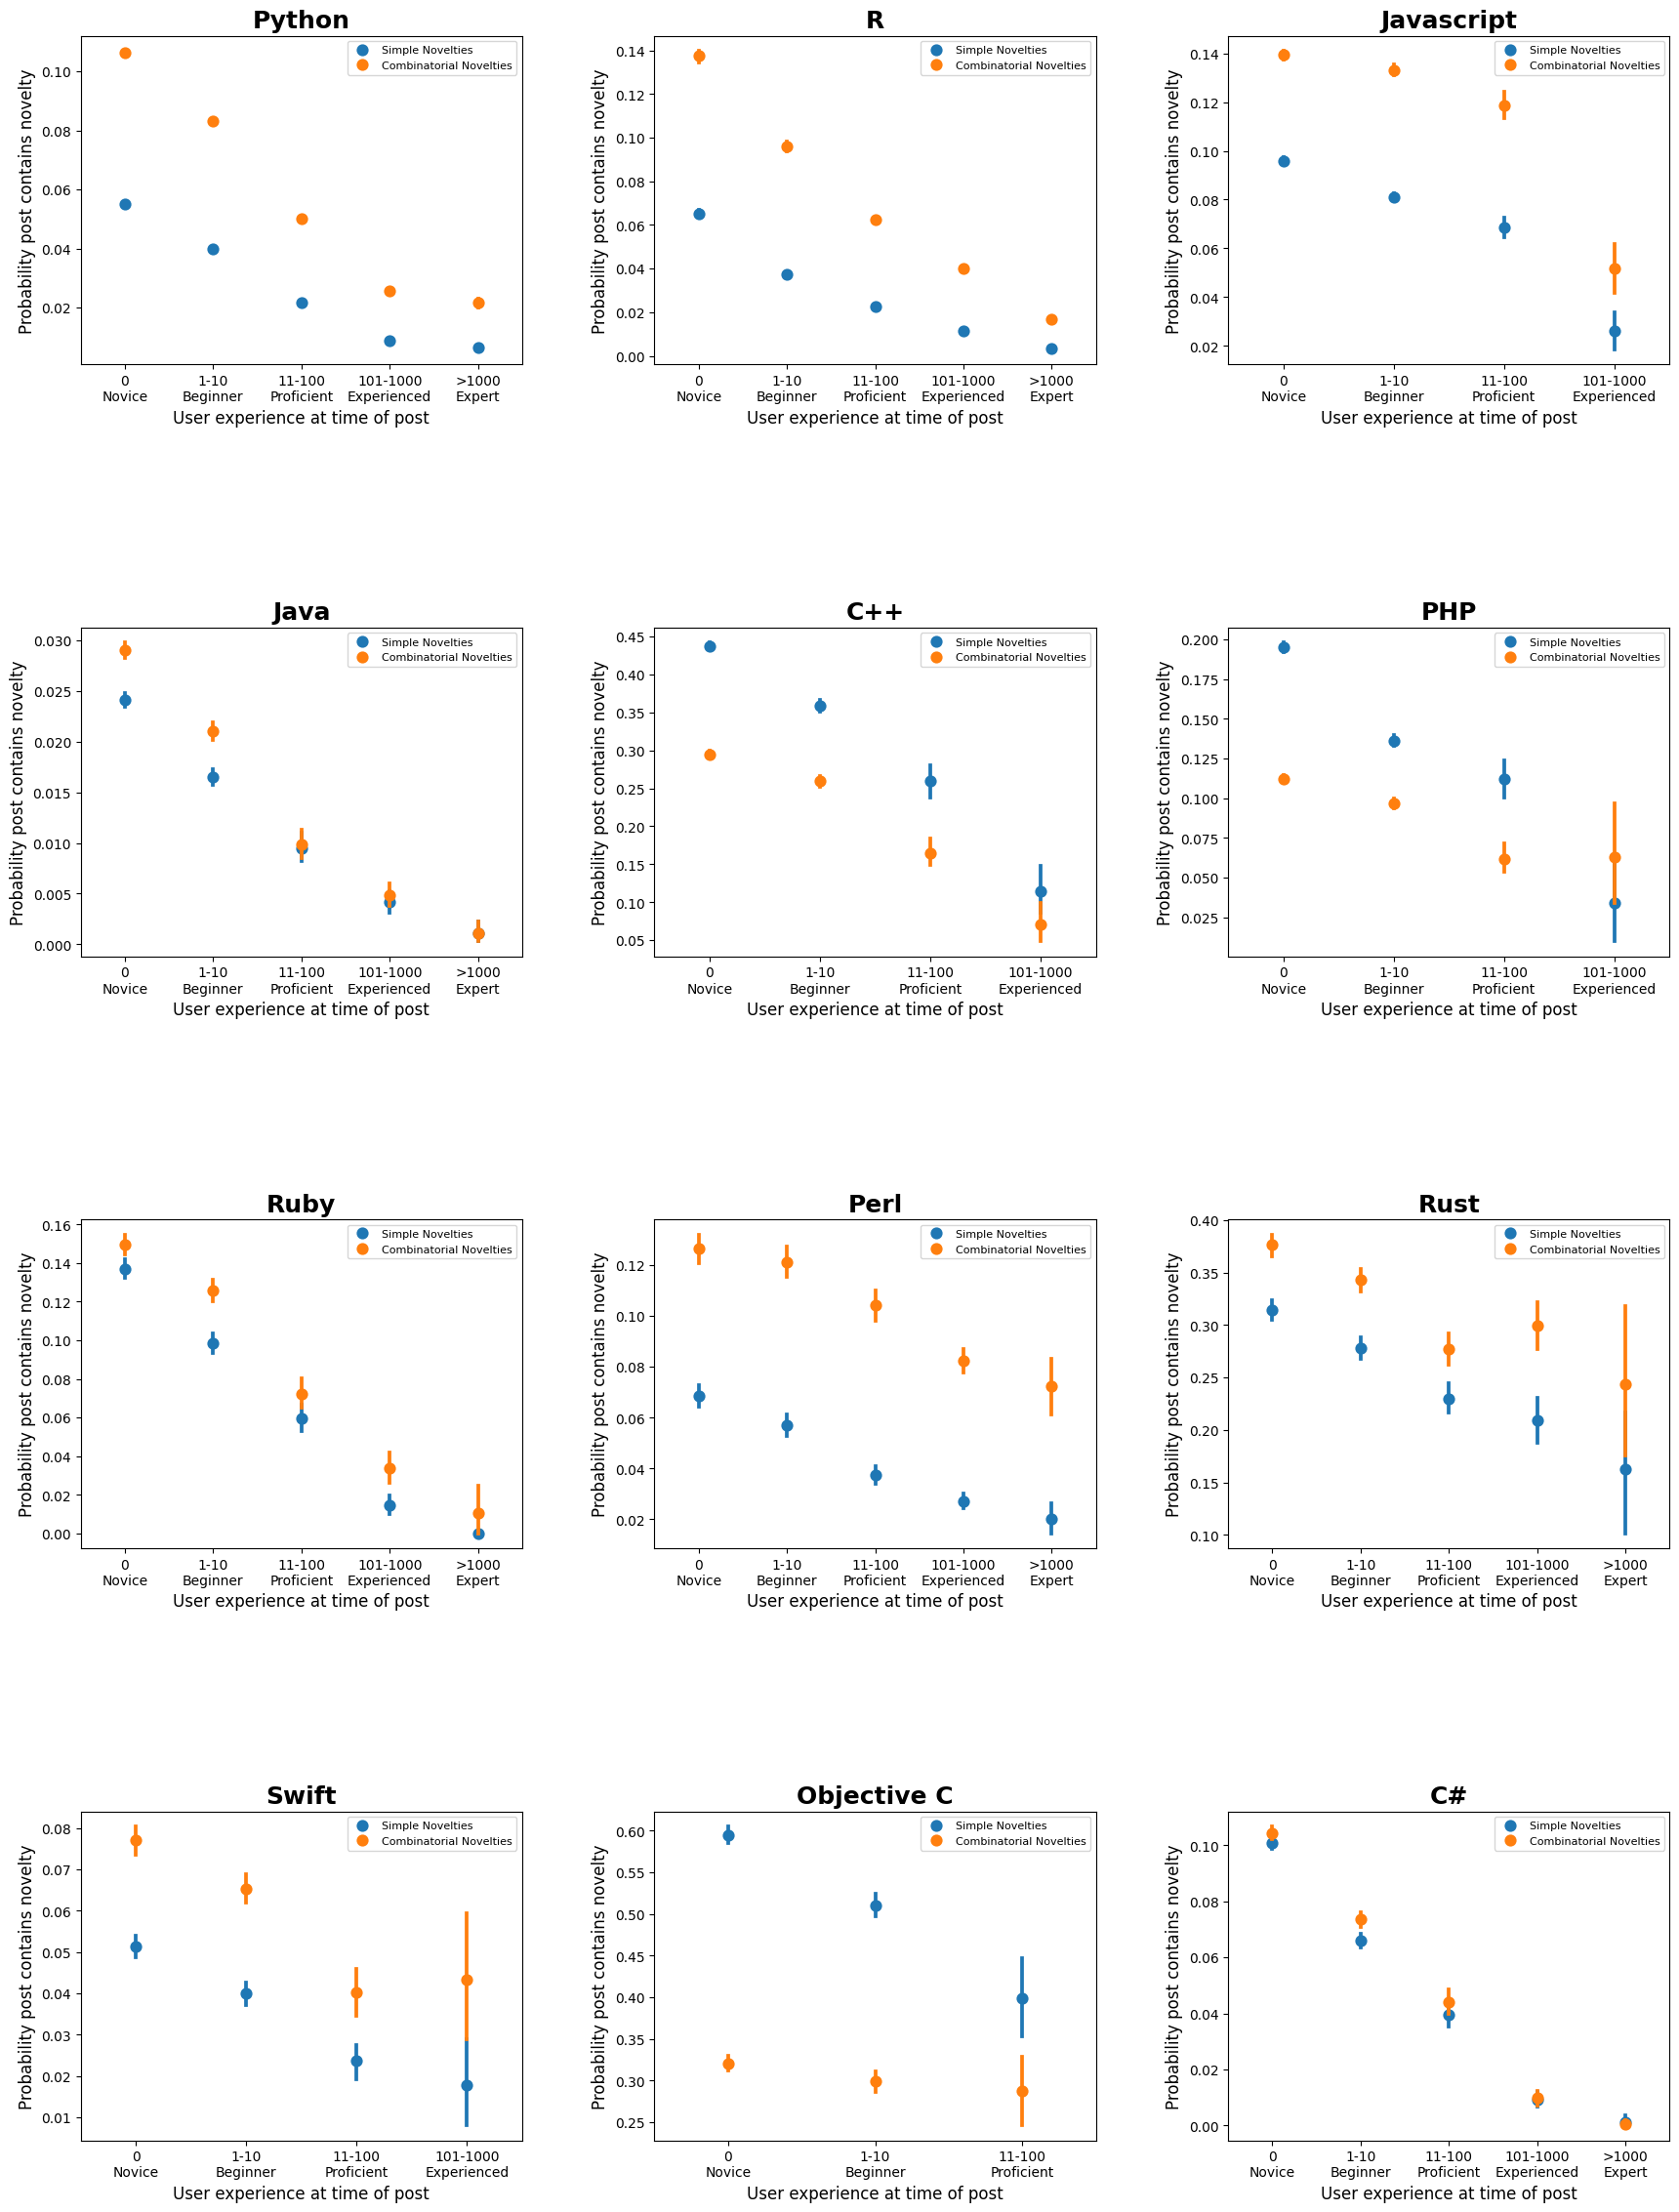

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter, LogFormatterExponent,LogFormatterMathtext


import time
from sklearn.linear_model import LinearRegression


%matplotlib inline

square_size = 7
rows, columns = (len(LANGUAGES) + 2) // 3, 3
fig = plt.figure(figsize=(square_size * columns, square_size * rows))
gs = GridSpec(rows, columns, figure=fig)
plt.subplots_adjust(hspace=0.8, wspace=0.3)


def get_user_category(number_of_previous_posts: int) -> str:
    if number_of_previous_posts == 0:
        return "0\nNovice"
    if 0 < number_of_previous_posts <= 10:
        return "1-10\nBeginner"
    if 10 < number_of_previous_posts <= 100:
        return "11-100\nProficient"
    if 100 < number_of_previous_posts <= 1000:
        return "101-1000\nExperienced"
    if 1000 < number_of_previous_posts:
        return ">1000\nExpert"
    raise ValueError(f"post count {number_of_previous_posts} should be a positive integer!")

TOTAL_INPUT = []
GEO_DIST = {level: collections.defaultdict(int) for level in (
    "Novice",
    "Beginner",
    "Proficient",
    "Experienced",
    "Expert",
)}


for index, language in enumerate(LANGUAGES):
    print(f"Processing {language}")
    path_to_lib = f"data/results/{language}"

    i, j = index // columns, index % columns
    ax = fig.add_subplot(gs[i, j])
    
    print("\t Processing resource...")
    user_post_count = collections.defaultdict(int)
    
    libs_df_input = []
    pairs_df_input = []
    
    with open(f"{path_to_lib}/{language}_time_based_new.jsonl") as handle:
        for line in handle:
            json_data = json.loads(line)
            TOTAL_INPUT.append(json_data)

            category = get_user_category(user_post_count[json_data["user_id"]])
            new_libs_row = [
                json_data["post_id"],
                bool(len(json_data.get("new_libs", []))),
                category,
            ]
            new_pairs_row = [
                json_data["post_id"],
                bool(len(json_data.get("new_pairs", []))),
                category,
            ]

            if json_data["user_id"] in geo_data and geo_data[json_data["user_id"]].get("country"):
                GEO_DIST[category.split("\n")[-1]][geo_data[json_data["user_id"]].get("country")] += 1
           
            user_post_count[json_data["user_id"]] += 1
            libs_df_input.append(new_libs_row)
            pairs_df_input.append(new_pairs_row)
        libs_df = pd.DataFrame(libs_df_input, columns=["Id", "Novel", "User_Type"])
        pairs_df = pd.DataFrame(pairs_df_input, columns=["Id", "Novel", "User_Type"])
        sns.pointplot(data=libs_df, x="User_Type", y="Novel", linestyles="", ax=ax, label="Simple Novelties")
        sns.pointplot(data=pairs_df, x="User_Type", y="Novel", linestyles="", ax=ax, label="Combinatorial Novelties")

        ax.set_title(f'{LANGUAGES[language]}', fontsize=18, fontweight='bold')
        ax.set_xlabel("User experience at time of post", fontsize=12)
        ax.set_ylabel("Probability post contains novelty", fontsize=12)
        ax.legend(fontsize=8, loc="upper right")
plt.savefig("experiences.png")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2846564/2846564 [00:17<00:00, 158555.04it/s]


Text(0.5, 1.0, 'All Studied Programming Languages')

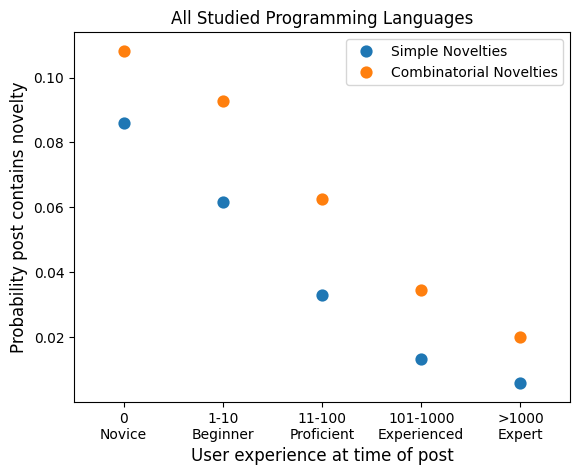

In [6]:
SORTED_TOTAL_INPUT = sorted(TOTAL_INPUT, key=lambda x: x.get("post_date"))

from tqdm import tqdm 
user_post_count = collections.defaultdict(int)
libs_rows = []
pairs_rows = []
for item in tqdm(SORTED_TOTAL_INPUT):
    new_libs_row = [
        json_data["post_id"],
        bool(len(item.get("new_libs", []))),
        get_user_category(user_post_count[item["user_id"]]),
        item["post_date"],
    ] 
    new_pairs_row = [
        json_data["post_id"],
        bool(len(item.get("new_pairs", []))),
        get_user_category(user_post_count[item["user_id"]]),
        item["post_date"],
    ] 
    user_post_count[item["user_id"]] += 1
    libs_rows.append(new_libs_row)
    pairs_rows.append(new_pairs_row)


libs_df = pd.DataFrame(libs_rows, columns=["Id", "Novel", "User_Type", "Date_Posted"])
pairs_df = pd.DataFrame(pairs_rows, columns=["Id", "Novel", "User_Type", "Date_Posted"])

sns.pointplot(data=libs_df, x="User_Type", y="Novel", linestyles="", label="Simple Novelties")
sns.pointplot(data=pairs_df, x="User_Type", y="Novel", linestyles="", label="Combinatorial Novelties")
plt.xlabel("User experience at time of post", fontsize=12)
plt.ylabel("Probability post contains novelty", fontsize=12)
plt.title("All Studied Programming Languages")